In [ ]:
# . . . . Importing Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

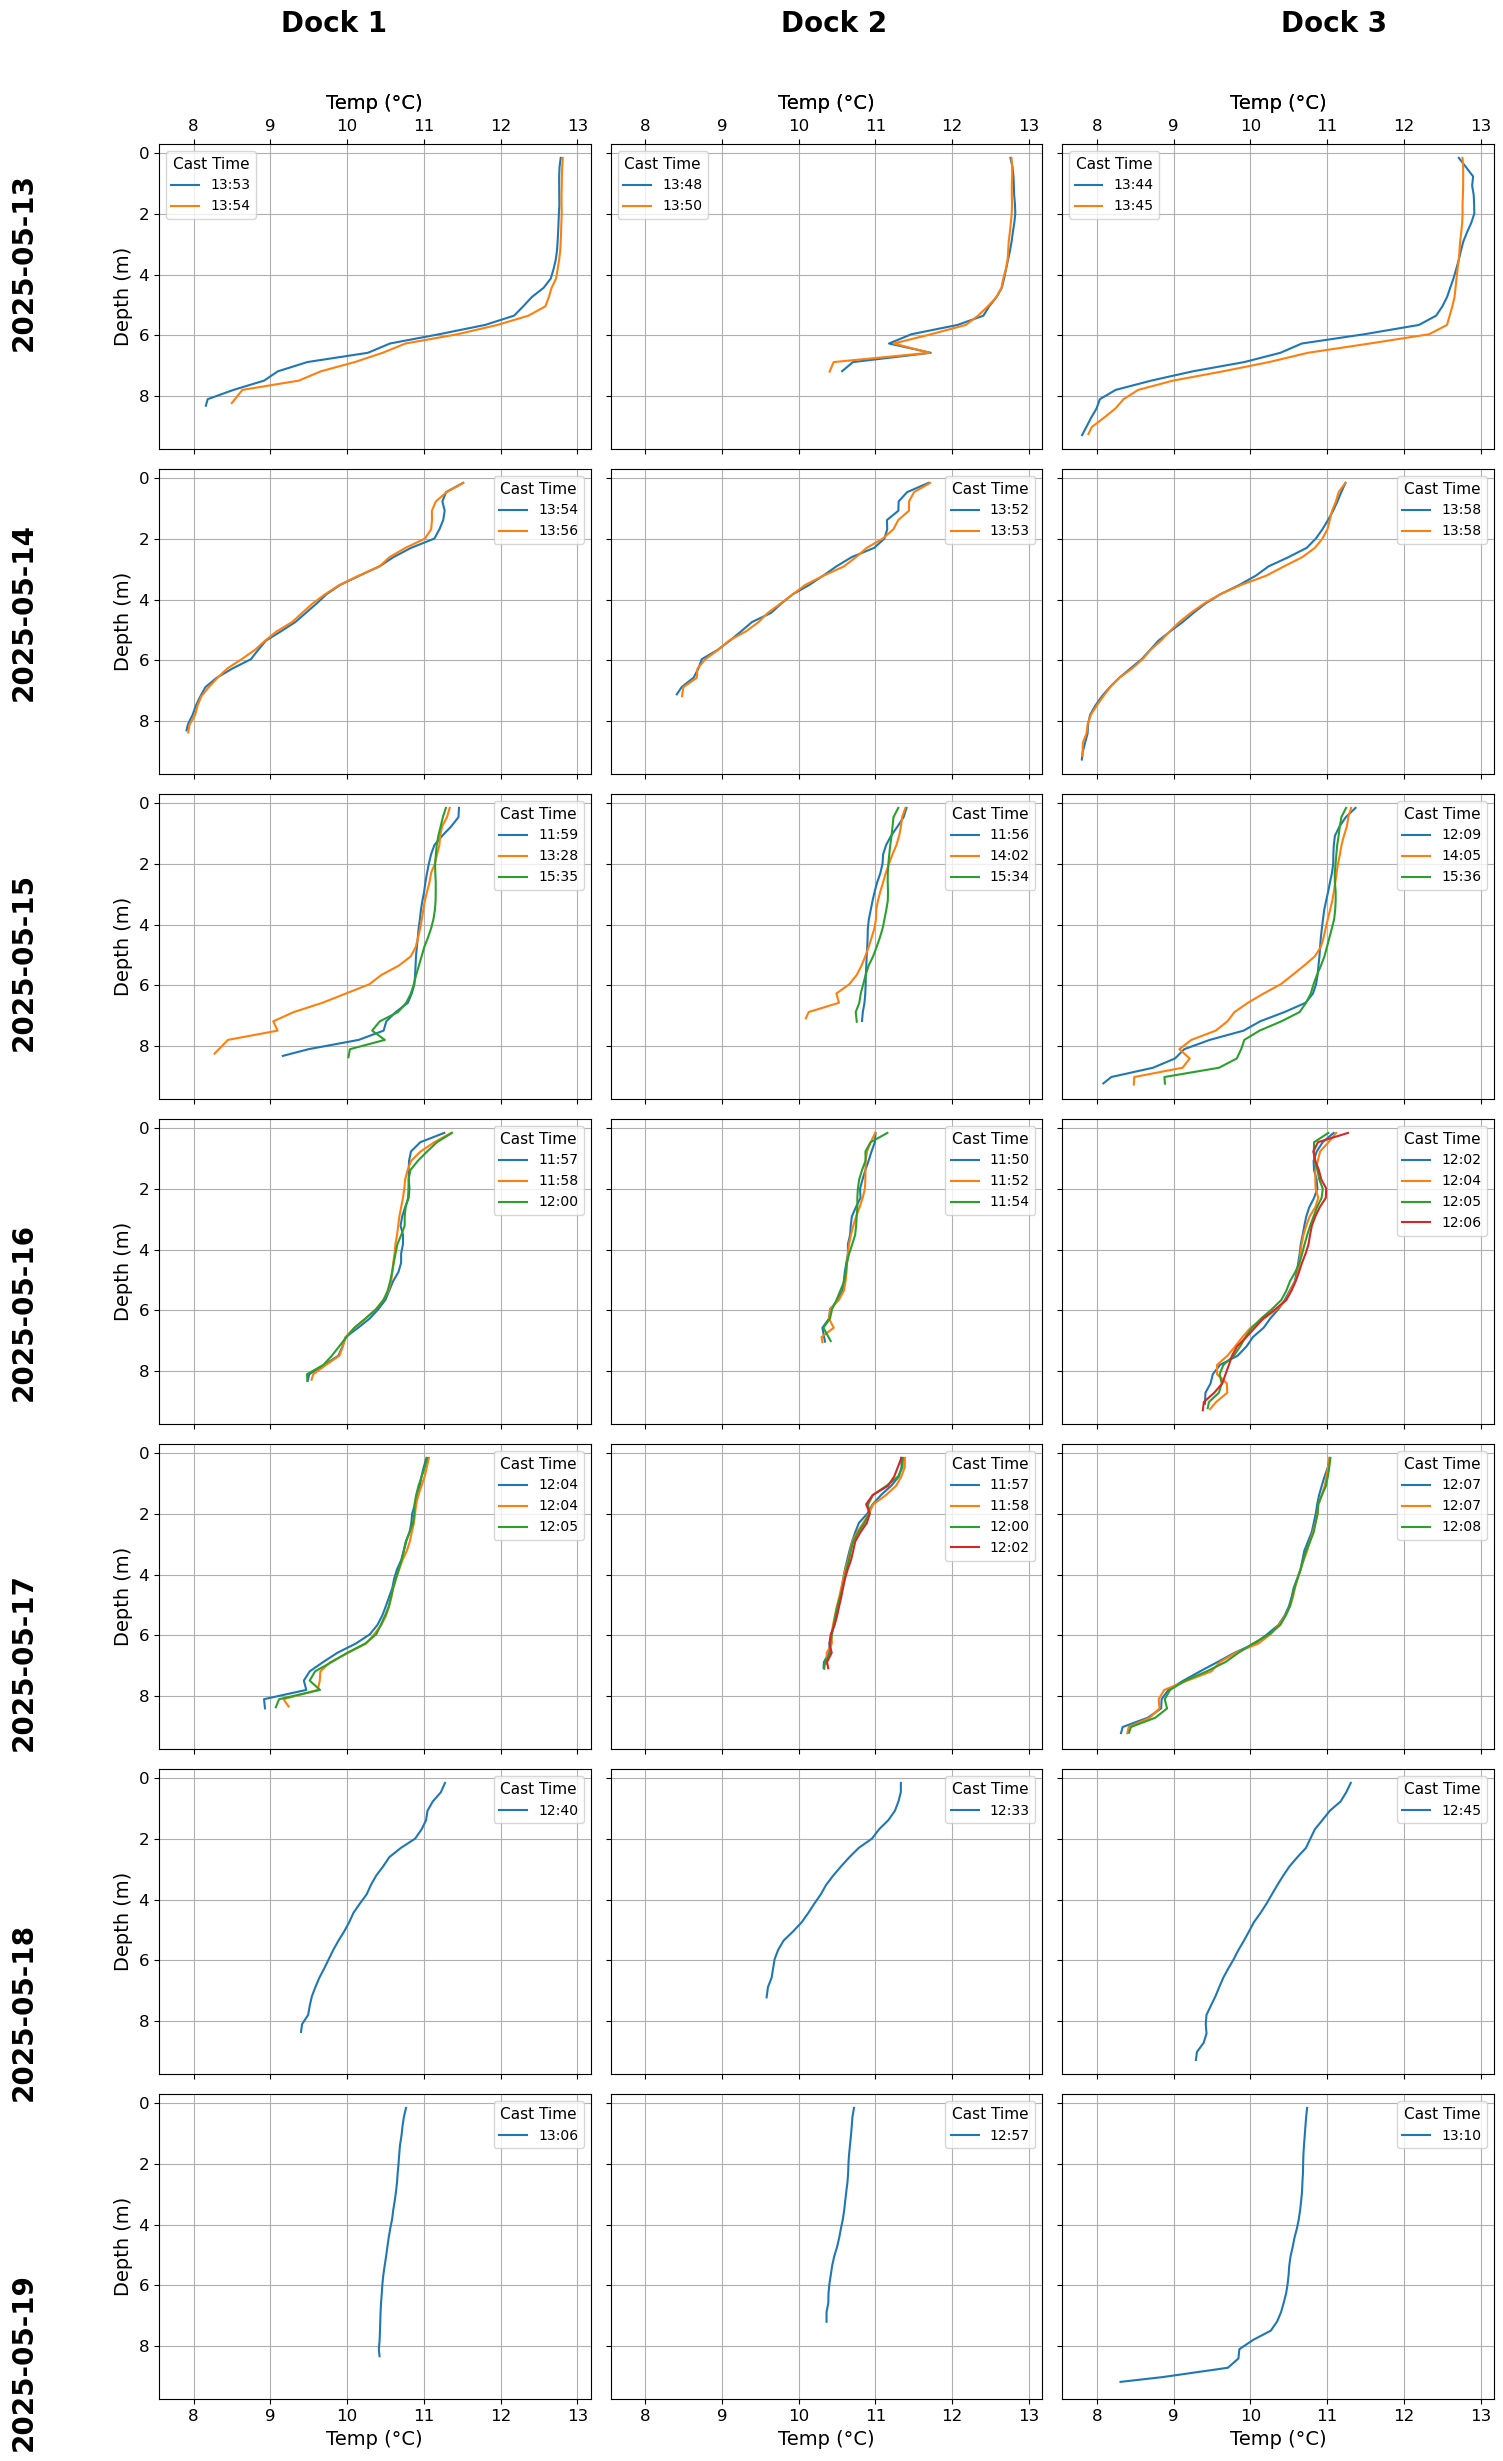

In [ ]:

# --- Load the data ---
file_path = '/Users/mariannamarquardt/Desktop/dock_casts_with_mld.csv'
df = pd.read_csv(file_path)

# --- Convert time column to datetime ---
df['Cast time (local)'] = pd.to_datetime(df['Cast time (local)'])

# --- Filter out casts with max depth < 6 m ---
max_depths = df.groupby('File name')['Depth (Meter)'].max()
valid_files = max_depths[max_depths >= 6].index
df = df[df['File name'].isin(valid_files)]

# --- Get metadata for subplot layout ---
meta = df.drop_duplicates('File name')[['File name', 'Cast time (local)', 'Dock Location']]
meta = meta.sort_values('Cast time (local)').reset_index(drop=True)

# --- Assign a dock column index ---
dock_order = {'Dock_1': 0, 'Dock_2': 1, 'Dock_3': 2}
meta['col'] = meta['Dock Location'].map(dock_order)

# --- Group by date and assign row index ---
meta['date'] = meta['Cast time (local)'].dt.date
unique_dates = sorted(meta['date'].unique())
date_to_row = {date: i for i, date in enumerate(unique_dates)}
meta['row'] = meta['date'].map(date_to_row)

n_rows = len(unique_dates)
n_cols = 3  # for 3 docks

# --- Create subplot grid ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3.5 * n_rows), sharex=True, sharey=True)
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)

# --- Plot each cast and store legends ---
for _, row in meta.iterrows():
    ax = axes[row['row'], row['col']]
    cast = df[df['File name'] == row['File name']]
    label = row['Cast time (local)'].strftime('%H:%M')
    ax.plot(cast['Temperature (Celsius)'], cast['Depth (Meter)'], linestyle='-', label=label)
    ax.invert_yaxis()
    ax.grid(True)
    if row['col'] == 0:
        ax.set_ylabel("Depth (m)", fontsize=14)
    if row['row'] == n_rows - 1:
        ax.set_xlabel("Temp (°C)", fontsize=14, fontweight='normal')  # bottom xlabel
    if row['row'] == 0:
        ax.tick_params(labeltop=True, top=True)
        ax.text(0.5, 1.1, "Temp (°C)", ha='center', va='bottom',
                fontsize=14, fontweight='normal', transform=ax.transAxes)
    ax.tick_params(labelsize=14)

# --- Add legends to each subplot ---
for i in range(n_rows):
    for j in range(n_cols):
        ax = axes[i, j]
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(title='Cast Time', fontsize=10, title_fontsize=11, loc='best')

# --- Remove empty subplots ---
for i in range(n_rows):
    for j in range(n_cols):
        if not ((meta['row'] == i) & (meta['col'] == j)).any():
            fig.delaxes(axes[i, j])

# --- Add column headers (centered and shifted right), lowered to reduce gap ---
dock_labels = ['Dock 1', 'Dock 2', 'Dock 3']
for col, label in enumerate(dock_labels):
    x_center = (col + 0.5) / n_cols + 0.05  # shift right
    fig.text(x_center, 0.99, label, ha='center', va='bottom', fontsize=20, fontweight='bold')

# --- Add row labels with date (centered and shifted down) ---
for row, date in enumerate(unique_dates):
    y_center = 1 - (row + 0.5) / n_rows - 0.03  # shift down
    fig.text(0.01, y_center, str(date), ha='center', va='center',
             fontsize=20, fontweight='bold', rotation=90)

# --- Final layout ---
plt.tight_layout(rect=[0.06, 0, 1, 0.97])
plt.show()


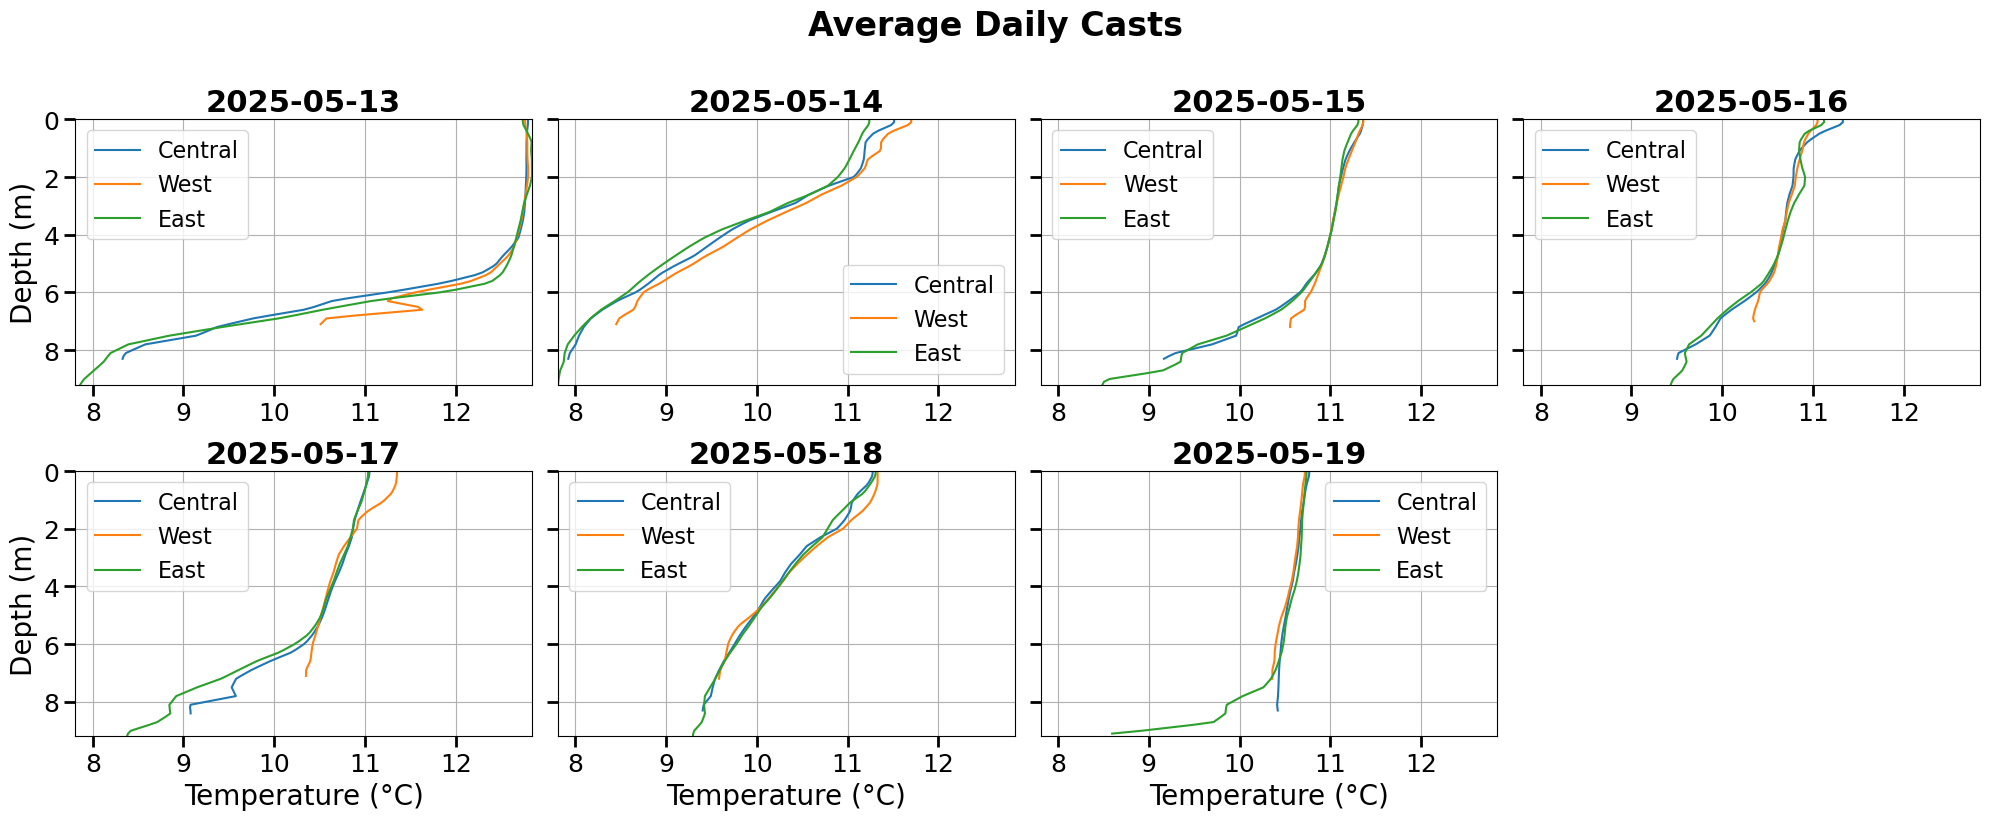

In [ ]:
# --- Re-load the data ---
file_path = '/Users/mariannamarquardt/Desktop/dock_casts_with_mld.csv'
df = pd.read_csv(file_path)

# --- Convert time column to datetime ---
df['Cast time (local)'] = pd.to_datetime(df['Cast time (local)'])
df['date'] = df['Cast time (local)'].dt.date

# --- Filter out casts with max depth < 6 m ---
max_depths = df.groupby('File name')['Depth (Meter)'].max()
valid_files = max_depths[max_depths >= 6].index
df = df[df['File name'].isin(valid_files)]

# --- Special handling for May 15: specific casts per dock ---
may15 = pd.to_datetime("2024-05-15").date()
may15_casts = {
    'Dock_1': '11:59',
    'Dock_2': '11:56',
    'Dock_3': '12:09'
}

df_filtered = pd.DataFrame()

for (dock, date), group in df.groupby(['Dock Location', 'date']):
    if date == may15:
        target_time = may15_casts.get(dock)
        if target_time:
            cast_times = group.groupby('File name')['Cast time (local)'].first()
            target_dt = pd.to_datetime(f"{may15} {target_time}")
            closest_file = (cast_times - target_dt).abs().idxmin()
            df_filtered = pd.concat([df_filtered, df[df['File name'] == closest_file]])
    else:
        df_filtered = pd.concat([df_filtered, group])

df = df_filtered.copy()

# --- Create averaged profiles per dock per date ---
avg_profiles = []

for (dock, date), group in df.groupby(['Dock Location', 'date']):
    # Interpolate all casts in the group to a common depth grid
    depth_grid = np.arange(0, group['Depth (Meter)'].max(), 0.1)
    casts = []

    for fname, cast in group.groupby('File name'):
        interp_temp = np.interp(depth_grid, cast['Depth (Meter)'], cast['Temperature (Celsius)'])
        casts.append(interp_temp)

    casts = np.array(casts)
    mean_temp = np.mean(casts, axis=0)

    avg_profiles.append(pd.DataFrame({
        'Dock': dock,
        'Date': date,
        'Depth': depth_grid,
        'Temperature': mean_temp
    }))

avg_df = pd.concat(avg_profiles, ignore_index=True)

# --- Determine global x and y limits for all plots ---
temp_min = avg_df['Temperature'].min()
temp_max = avg_df['Temperature'].max()
depth_min = avg_df['Depth'].min()
depth_max = avg_df['Depth'].max()

# --- Plot: One subplot per day, all docks overlaid in a grid ---
unique_dates = sorted(avg_df['Date'].unique())
n_plots = len(unique_dates)

# Determine grid size (4 columns)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=True)
axes = axes.flatten()  # flatten to 1D array for easy indexing

fig.suptitle("Average Daily Casts", fontsize=24, weight='bold', y=1.02)

dock_colors = {
    'Dock_1': ('tab:blue', 'Central'),
    'Dock_2': ('tab:orange', 'West'),
    'Dock_3': ('tab:green', 'East')
}

for i, date in enumerate(unique_dates):
    ax = axes[i]
    day_data = avg_df[avg_df['Date'] == date]

    for dock, (color, label) in dock_colors.items():
        dock_data = day_data[day_data['Dock'] == dock]
        if not dock_data.empty:
            ax.plot(dock_data['Temperature'], dock_data['Depth'], label=label, color=color)

    ax.set_title(str(date), fontsize=22, weight='bold')
    ax.invert_yaxis()
    ax.grid(True)

    # Increase tick label font size and tick size
    ax.tick_params(axis='both', which='major', labelsize=18, length=8, width=2)

    # Set common x and y limits for all subplots
    ax.set_xlim(temp_min, temp_max)
    ax.set_ylim(depth_max, depth_min)

    # Label y-axis only on left column subplots
    if i % n_cols == 0:
        ax.set_ylabel("Depth (m)", fontsize=20)

    # Label x-axis on bottom row subplots
    if i // n_cols == n_rows - 1 or i in [16, 17]:
        ax.set_xlabel("Temperature (°C)", fontsize=20)

    ax.legend(fontsize=16)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


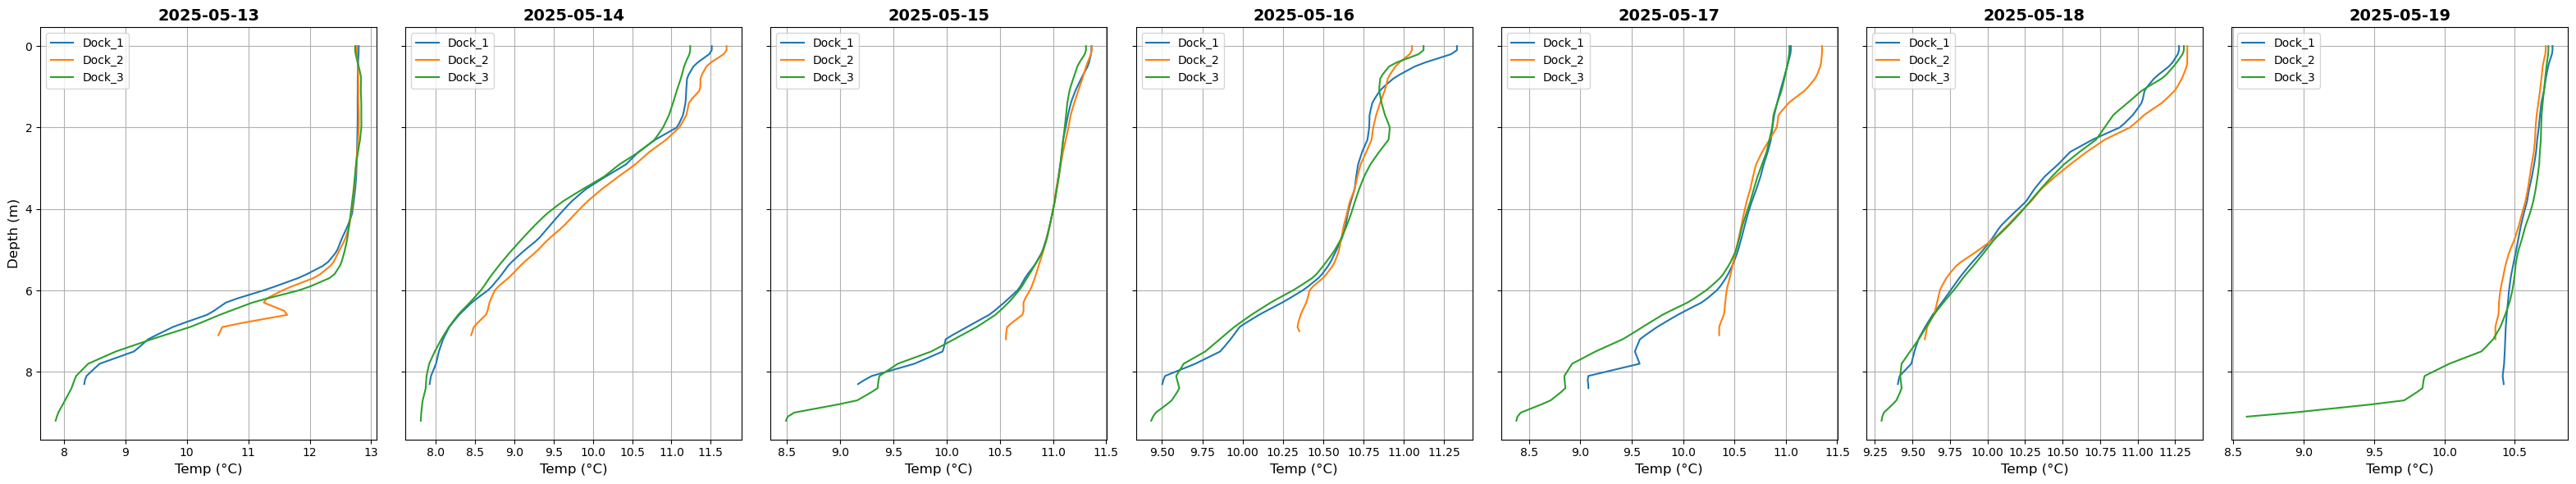

In [ ]:
# --- Load the data ---
file_path = '/Users/mariannamarquardt/Desktop/dock_casts_with_mld.csv'
df = pd.read_csv(file_path)

# --- Convert time column to datetime ---
df['Cast time (local)'] = pd.to_datetime(df['Cast time (local)'])
df['date'] = df['Cast time (local)'].dt.date

# --- Filter out casts with max depth < 6 m ---
max_depths = df.groupby('File name')['Depth (Meter)'].max()
valid_files = max_depths[max_depths >= 6].index
df = df[df['File name'].isin(valid_files)]

# --- Special handling for May 15: specific casts per dock ---
may15 = pd.to_datetime("2024-05-15").date()
may15_casts = {
    'Dock_1': '11:59',
    'Dock_2': '11:56',
    'Dock_3': '12:09'
}

df_filtered = pd.DataFrame()

for (dock, date), group in df.groupby(['Dock Location', 'date']):
    if date == may15:
        target_time = may15_casts.get(dock)
        if target_time:
            cast_times = group.groupby('File name')['Cast time (local)'].first()
            target_dt = pd.to_datetime(f"{may15} {target_time}")
            closest_file = (cast_times - target_dt).abs().idxmin()
            df_filtered = pd.concat([df_filtered, df[df['File name'] == closest_file]])
    else:
        df_filtered = pd.concat([df_filtered, group])

df = df_filtered.copy()

# --- Create averaged profiles per dock per date ---
avg_profiles = []

for (dock, date), group in df.groupby(['Dock Location', 'date']):
    depth_grid = np.arange(0, group['Depth (Meter)'].max(), 0.1)
    casts = []

    for fname, cast in group.groupby('File name'):
        interp_temp = np.interp(depth_grid, cast['Depth (Meter)'], cast['Temperature (Celsius)'])
        casts.append(interp_temp)

    casts = np.array(casts)
    mean_temp = np.mean(casts, axis=0)

    avg_profiles.append(pd.DataFrame({
        'Dock': dock,
        'Date': date,
        'Depth': depth_grid,
        'Temperature': mean_temp
    }))

avg_df = pd.concat(avg_profiles, ignore_index=True)

# --- Plot: One row of subplots (one column per date) ---
unique_dates = sorted(avg_df['Date'].unique())
n_cols = len(unique_dates)

fig, axes = plt.subplots(1, n_cols, figsize=(4.5 * n_cols, 6), sharey=True)
if n_cols == 1:
    axes = [axes]

dock_colors = {'Dock_1': 'tab:blue', 'Dock_2': 'tab:orange', 'Dock_3': 'tab:green'}

for i, date in enumerate(unique_dates):
    ax = axes[i]
    day_data = avg_df[avg_df['Date'] == date]

    for dock in ['Dock_1', 'Dock_2', 'Dock_3']:
        dock_data = day_data[day_data['Dock'] == dock]
        if not dock_data.empty:
            ax.plot(dock_data['Temperature'], dock_data['Depth'], label=dock, color=dock_colors[dock])

    ax.set_title(f"{date}", fontsize=14, weight='bold')
    ax.invert_yaxis()
    ax.grid(True)
    ax.set_xlabel("Temp (°C)", fontsize=12)
    if i == 0:
        ax.set_ylabel("Depth (m)", fontsize=12)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


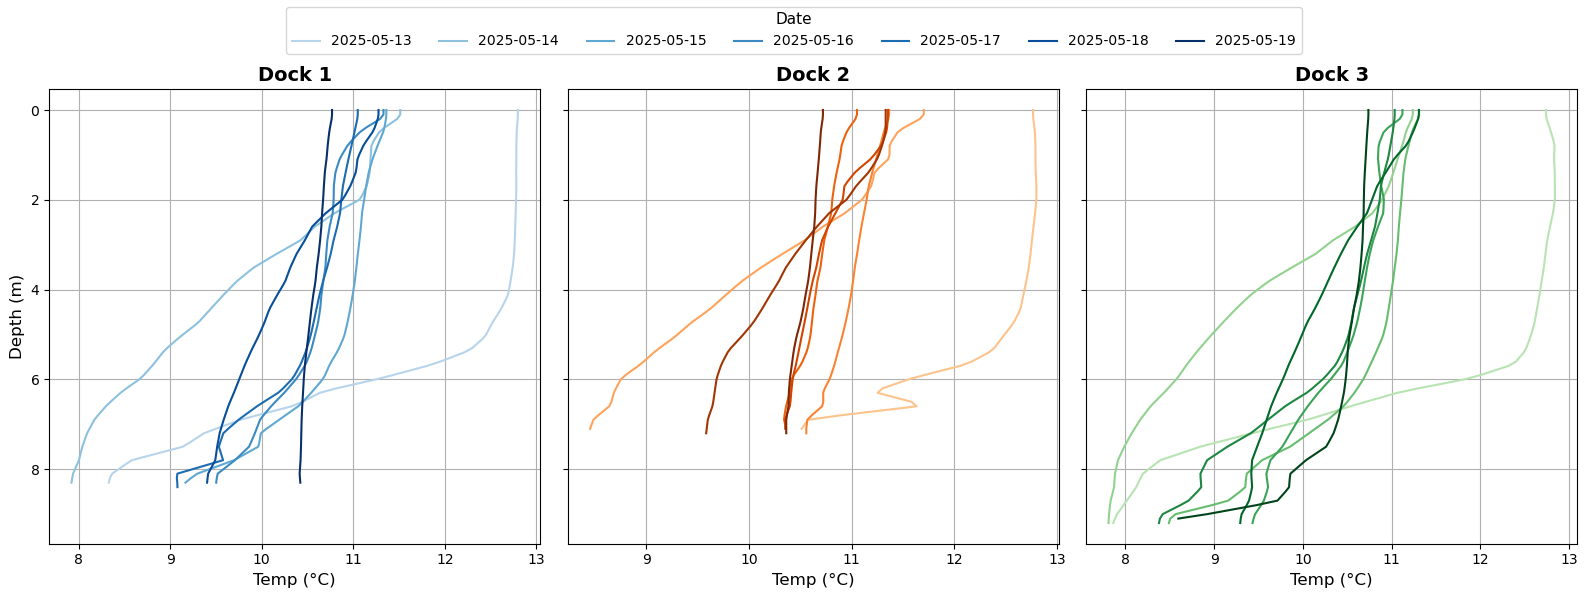

In [ ]:
# --- Setup dock-wise plot ---
fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

dock_names = ['Dock_1', 'Dock_2', 'Dock_3']
dock_colormaps = {
    'Dock_1': cm.Blues,
    'Dock_2': cm.Oranges,
    'Dock_3': cm.Greens
}

# --- Sort dates ---
unique_dates = sorted(avg_df['Date'].unique())
n_dates = len(unique_dates)
norm = mcolors.Normalize(vmin=0, vmax=n_dates - 1)

# --- Plot for each dock ---
for i, dock in enumerate(dock_names):
    ax = axes[i]
    dock_data = avg_df[avg_df['Dock'] == dock]

    # Limit the lightest color to avoid washed-out lines
    color_vals = np.linspace(0.3, 1, n_dates)  # <-- Adjust range here

    for j, date in enumerate(unique_dates):
        day_data = dock_data[dock_data['Date'] == date]
        if not day_data.empty:
            color = dock_colormaps[dock](color_vals[j])
            ax.plot(day_data['Temperature'], day_data['Depth'], label=str(date), color=color)


    ax.set_title(dock.replace('_', ' '), fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True)
    ax.set_xlabel("Temp (°C)", fontsize=12)
    if i == 0:
        ax.set_ylabel("Depth (m)", fontsize=12)
    ax.tick_params(labelsize=10)

# --- Add one legend outside the plot ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Date', loc='upper center', ncol=n_dates, fontsize=10, title_fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
